# In this notebook, a VAE is trained and used to generate new samples

In [1]:
import utils_ML as uml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, normalize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision

device = 'cuda' if torch.cuda.is_available() else "cpu"

In [2]:
# read data

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()

class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 7: 3.453333333333333, 9: 0.7194444444444444, 1: 0.3453333333333333, 0: 0.4427350427350427, 8: 1.5014492753623188, 14: 3.453333333333333, 6: 0.5755555555555556, 3: 2.3022222222222224, 11: 1.3282051282051281, 5: 1.4388888888888889, 12: 1.4388888888888889, 10: 1.3282051282051281, 4: 0.8222222222222222, 13: 1.817543859649123}


In [3]:
preprocessor = Pipeline(steps=[
    ('filtering', uml.FilterByClass(keep=True)),
    ('imputation', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler()),
])

In [5]:
processed_data = preprocessor.fit_transform(data, targets)
processed_data = processed_data.astype('float32')

In [6]:
processed_data_df = pd.DataFrame(processed_data, columns = preprocessor.named_steps.filtering.filtered_proteins, index=data.index)

In [34]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        self.linear1 = nn.Linear(6703, 1000)
        self.linear2 = nn.Linear(1000, latent_dims)
        self.linear3 = nn.Linear(1000, latent_dims)

        self.N = torch.distributions.Normal(0,1)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = self.linear1(x)
        x = F.relu(x)

        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))

        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Linear(latent_dims, 1000)
        self.linear2 = nn.Linear(1000, 6703)

    def forward(self, z):
        z = self.linear1(z)
        z = F.relu(z)

        z = self.linear2(z)
        z = torch.sigmoid(z)

        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()

        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)

        return reconstruction
    
def trainVAE(autoencoder: VariationalAutoencoder, data, epochs = 20):
    optimization = torch.optim.Adam(autoencoder.parameters())

    running_loss = 0
    last_loss = 0

    for epoch in range(epochs):
        print(epoch)

        for i, x in enumerate(data):
            x = x.to(device)
            optimization.zero_grad()
            x_hat = autoencoder(x)

            loss = ((x-x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            optimization.step()
        
            running_loss += loss.item()

            if i == 129:
                last_loss = running_loss/129
                print('batch {} loss: {}'.format(i + 1, last_loss))

                running_loss = 0
        print(loss)
    return autoencoder

def trainDVAE2(autoencoder: VariationalAutoencoder, data, validation_data, epochs = 20):
    optimization = torch.optim.Adam(autoencoder.parameters())

    training_losses = []
    validation_losses = []

    running_loss = 0
    last_loss = 0

    for epoch in range(epochs):

        for label, (x_1, x_2) in data:

            x_1 = x_1.to(device)
            optimization.zero_grad()

            x1_hat = autoencoder(x_1)
            x2_hat = autoencoder(x_2)

            reconstruction_error = ((x_1-x1_hat)**2).sum() # Reconstructed datapoint must be similar
            intra_class_difference_error = ((x1_hat-x2_hat)**2).sum() # Incentivize class identity reconstruction by using other samples from the same class
            kullback_leibler = autoencoder.encoder.kl # Error term to ensure a smooth latent space

            loss = reconstruction_error + intra_class_difference_error + kullback_leibler
            loss.backward()
            optimization.step()

            running_loss += loss.item()

        last_loss = running_loss / len(data)
        print('  epoch {} loss: {}'.format(epoch, last_loss))
        training_losses.append(last_loss)
        
        running_loss = 0
        valid_loss = 0

        for label, (x_1, x_2) in validation_data:

            x1_hat = autoencoder(x_1)
            x2_hat = autoencoder(x_2)
            
            reconstruction_error = ((x_1-x1_hat)**2).sum() 
            intra_class_difference_error = ((x1_hat-x2_hat)**2).sum()
            kullback_leibler = autoencoder.encoder.kl

            loss = reconstruction_error + intra_class_difference_error + kullback_leibler

            valid_loss += loss.item()
        
        valid_loss = valid_loss/len(validation_data)
        print('     Validation loss: {}\n'.format(valid_loss))
        validation_losses.append(valid_loss)

    return autoencoder, training_losses, validation_losses

In [30]:
class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, targets):
        self.dataset = dataset
        self.targets = targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image1 = self.dataset[index]
        label1 = self.targets[index]
        
        while True:
            index2 = torch.randint(len(self.dataset), size=(1,)).item()
            image2, label2 = self.dataset[index2], self.targets[index2]
            if label2 == label1 and index != index2:
                break

        return label1, (image1, image2)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, targets, test_size=0.20, random_state=42, stratify=targets)

train_paired_dataset = PairedDataset(X_train, y_train)
test_paired_dataset = PairedDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_paired_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_paired_dataset, batch_size=10, shuffle=True)

# Denoising Variational autoencoder

In [73]:
vae = VariationalAutoencoder(latent_dims=20).to(device)
vae = trainDVAE2(vae, train_loader, test_loader, epochs = 100)

  epoch 0 loss: 5182.928030831473
     Validation loss: 3953.6820734197445

  epoch 1 loss: 4109.563848586309
     Validation loss: 3695.2867542613635

  epoch 2 loss: 3783.8855736142114
     Validation loss: 3597.1584028764205

  epoch 3 loss: 3687.5693708147323
     Validation loss: 3485.1308038884945

  epoch 4 loss: 3634.448724655878
     Validation loss: 3487.7450949928975

  epoch 5 loss: 3572.932576497396
     Validation loss: 3467.4409401633525

  epoch 6 loss: 3513.64210437593
     Validation loss: 3576.8861860795455

  epoch 7 loss: 3542.6673874627977
     Validation loss: 3357.320157137784

  epoch 8 loss: 3475.664280482701
     Validation loss: 3304.3419078480115

  epoch 9 loss: 3429.765898204985
     Validation loss: 3396.0602583451705

  epoch 10 loss: 3494.472499302455
     Validation loss: 3329.0052601207385

  epoch 11 loss: 3437.5020286923364
     Validation loss: 3370.6400923295455

  epoch 12 loss: 3388.917250860305
     Validation loss: 3453.0990656072445

  epoch

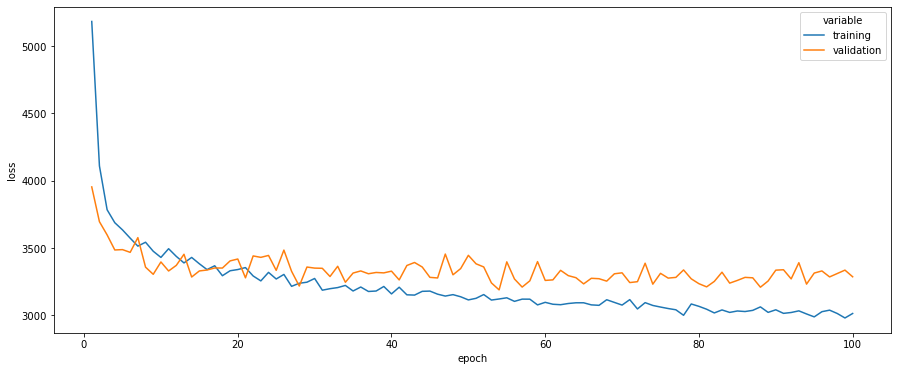

In [78]:
plt.figure(figsize=(15,6))
train_score, val_score = vae[1], vae[2]
scores= pd.DataFrame({'training': train_score, 'validation': val_score}).melt()
scores = pd.concat([pd.Series(list(range(1,101))*2), scores], axis=1).rename(columns={0:"epoch", "value": "loss"})
sns.lineplot(data=scores, x="epoch", y = "loss", hue="variable")

In [86]:
def useVAE(vae, data):
    """
    Returns encodings and reconstructed data

    Accepts a numpy array as data and an autoencoder
    """
    input_data = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)

    flag = True
    for datapoint in input_data:
        
        encoding = vae.encoder(datapoint)
        if flag:
            encodings = encoding.detach().numpy()[0]
            reconstructed = vae.decoder(encoding).detach().numpy()[0]
            flag = False

            continue

        encodings = np.vstack([encodings, encoding.detach().numpy()[0]])
        reconstructed = np.vstack([reconstructed, vae.decoder(encoding).detach().numpy()[0]])

    return encodings, reconstructed

def SampleVAE(vae, sample, n):
    """
    Generate n samples of sample with vae

    Returns encodings and reconstructed sample
    """
    sample = torch.Tensor(sample)

    flag = True
    for repeat in range(n):
        encoding = vae.encoder(sample)
        if flag:
            encodings = encoding.detach().numpy()[0]
            reconstructed = vae.decoder(encoding).detach().numpy()[0]
            flag = False
            continue
        
        encoding = np.vstack([encodings, encoding.detach().numpy()[0]])
        reconstructed = np.vstack([reconstructed, vae.decoder(encoding).detach().numpy()[0]])
    
    return encodings, reconstructed

In [100]:
X_train[0]

array([0.31938526, 0.        , 0.790462  , ..., 0.57655066, 0.6408523 ,
       0.        ], dtype=float32)

In [97]:
repeats = X_train[0]
for x in range(99):
    np.add(repeats, X_train[0])

In [101]:
repeats

array([0.31938526, 0.        , 0.790462  , ..., 0.57655066, 0.6408523 ,
       0.        ], dtype=float32)

In [94]:
torch.Tensor(X_train[0]).shape

torch.Size([6703])

In [76]:
encodings_train, reconstructed_train = useVAE(vae[0], X_train)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'ran

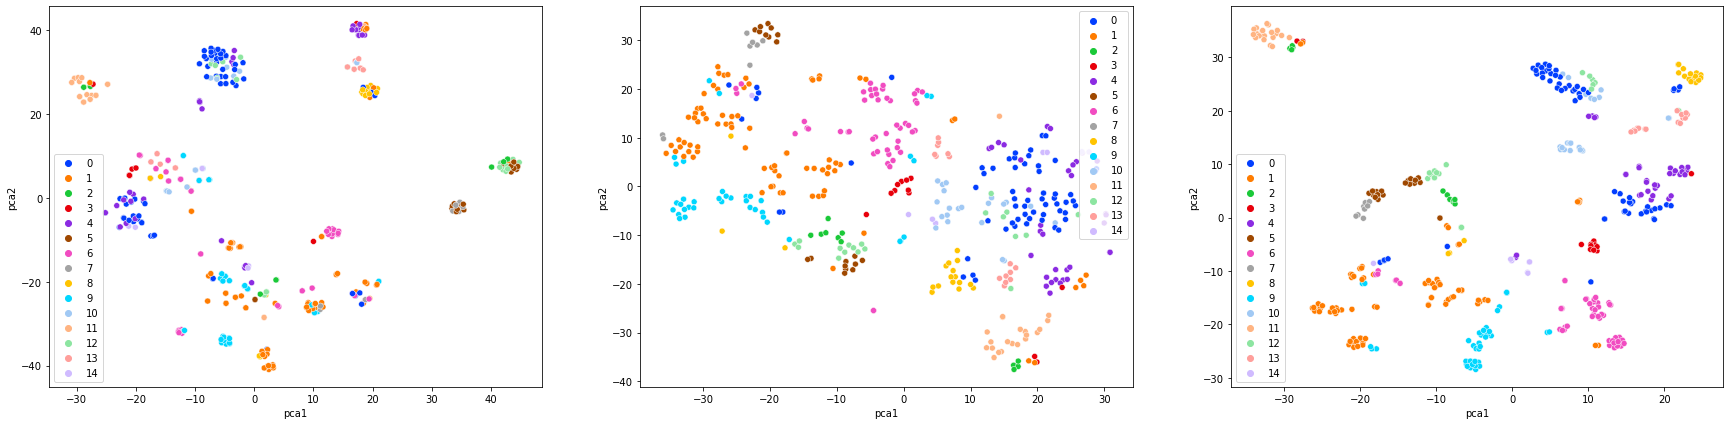

In [77]:
fig, ax = plt.subplots(1,3, figsize=(30,7))

pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(X_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[0], palette=colors)

embeddings = pca.fit_transform(encodings_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[1], palette=colors)

embeddings = pca.fit_transform(reconstructed_train)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_train, ax=ax[2], palette=colors)

In [80]:
encodings_test, reconstructed_test = useVAE(vae[0], X_test)

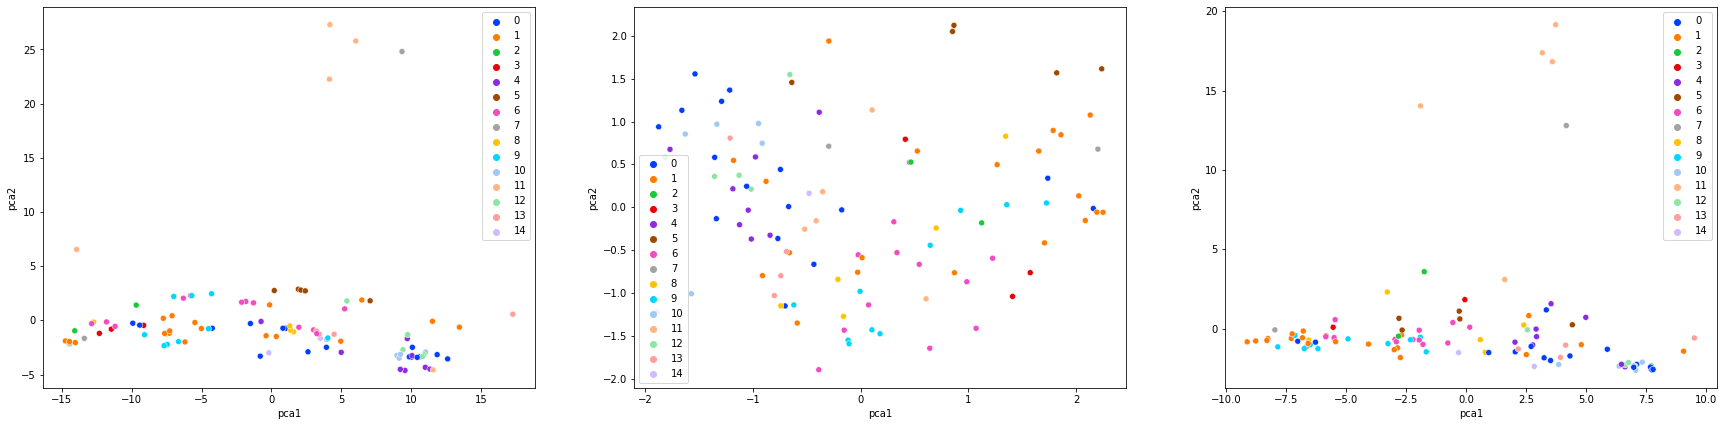

In [83]:
fig, ax = plt.subplots(1,3, figsize=(30,7))

pca = PCA(n_components=2)

embeddings = pca.fit_transform(X_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_test, ax=ax[0], palette=colors)

embeddings = pca.fit_transform(encodings_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_test, ax=ax[1], palette=colors)

embeddings = pca.fit_transform(reconstructed_test)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = y_test, ax=ax[2], palette=colors)

How different is are the latent variables for the same sample. Is is too discrete?

In [88]:
X_train[0]

array([0.31938526, 0.        , 0.790462  , ..., 0.57655066, 0.6408523 ,
       0.        ], dtype=float32)

In [91]:
encodings_train, reconstructed_train = SampleVAE(vae[0], X_train[0], 100)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [65]:
hela_breast = meta[meta.Group.isin(["HeLa", "Ductal_breast"])]

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


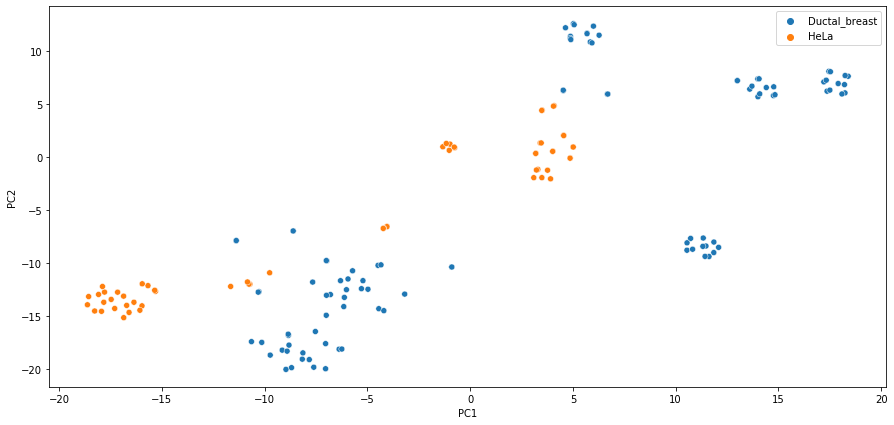

In [68]:
pca = TSNE(perplexity=20)

embeddings = pca.fit_transform(processed_data_df.loc[hela_breast.index, :])

plt.figure(figsize=(15,7))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = hela_breast.Group.tolist())

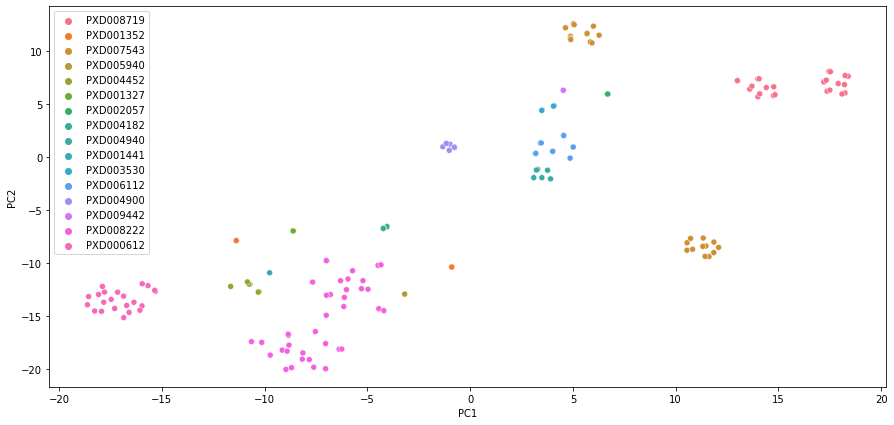

In [70]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = hela_breast.PXD_accession.tolist())

In [106]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, targets, test_size=0.20, random_state=42, stratify=targets)

In [107]:
train_data = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_data = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

In [108]:
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=10)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=10)

In [113]:
vae = VariationalAutoencoder(20)

In [116]:
vae, training_loss, validation_loss = trainDVAE2(vae, dataloader_train, dataloader_test, 10)

  epoch 0 loss: 167.953265848943
     Validation loss: 163.95767409984882

  epoch 1 loss: 156.77086031264153
     Validation loss: 149.9747409086961

  epoch 2 loss: 145.54097727531396
     Validation loss: 137.47568680689886



KeyboardInterrupt: 

In [111]:
#dataloader_bs1 = torch.utils.data.DataLoader(processed_data, batch_size = 1, shuffle=False)

In [234]:
vae = trainVAE(vae, dataloader, epochs = 30)

0
tensor(767.3354, grad_fn=<AddBackward0>)
1
tensor(865.1193, grad_fn=<AddBackward0>)
2
tensor(844.0660, grad_fn=<AddBackward0>)
3
tensor(881.5931, grad_fn=<AddBackward0>)
4
tensor(941.1876, grad_fn=<AddBackward0>)
5
tensor(697.2341, grad_fn=<AddBackward0>)
6
tensor(600.4299, grad_fn=<AddBackward0>)
7
tensor(675.9283, grad_fn=<AddBackward0>)
8
tensor(728.9360, grad_fn=<AddBackward0>)
9
tensor(803.1388, grad_fn=<AddBackward0>)
10
tensor(922.8105, grad_fn=<AddBackward0>)
11
tensor(684.8820, grad_fn=<AddBackward0>)
12
tensor(667.9693, grad_fn=<AddBackward0>)
13
tensor(815.0889, grad_fn=<AddBackward0>)
14
tensor(613.2781, grad_fn=<AddBackward0>)
15
tensor(658.9448, grad_fn=<AddBackward0>)
16
tensor(812.0526, grad_fn=<AddBackward0>)
17
tensor(682.0793, grad_fn=<AddBackward0>)
18
tensor(742.8961, grad_fn=<AddBackward0>)
19
tensor(807.4932, grad_fn=<AddBackward0>)
20
tensor(582.9099, grad_fn=<AddBackward0>)
21
tensor(799.0953, grad_fn=<AddBackward0>)
22
tensor(808.1902, grad_fn=<AddBackward0>

In [29]:
neuroblast_data = processed_data_df.loc[meta[meta.Group == "Neuroblastoma"].index, :]

In [70]:
neuroblast_data.shape

(48, 2615)

In [ ]:
torch.utils.data.DataLoader(processed_data, batch_size = 4, shuffle=True)

In [38]:
for x in dataloader:
    print(x.shape)
    break

torch.Size([4, 2615])


In [110]:
dataloader_neuro = torch.utils.data.DataLoader(neuroblast_data.to_numpy(), batch_size = 1)

In [121]:
flag = True
for neuro_sample in dataloader_neuro:
    
    neuro_sample = np.array(neuro_sample)
    neuro_sample = torch.Tensor(neuro_sample)

    if flag:
        neuro_encodings = vae.encoder(neuro_sample).detach().numpy()[0]
        flag = False
        continue
    
    neuro_encodings = np.vstack([neuro_encodings, vae.encoder(neuro_sample).detach().numpy()[0]])

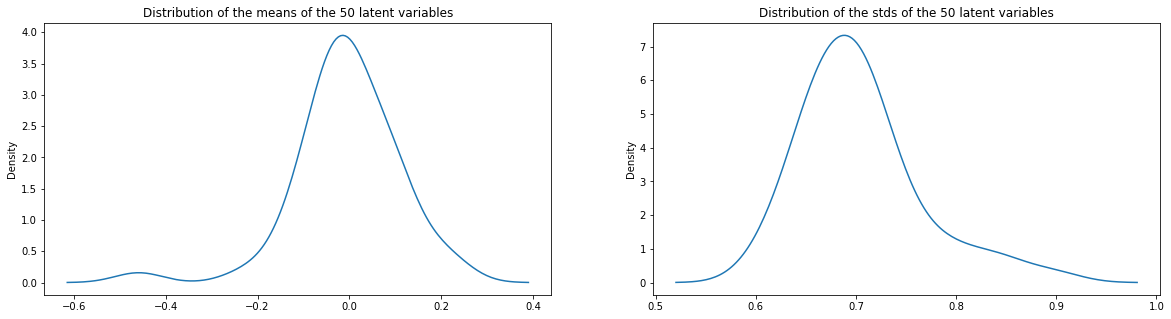

In [122]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].set_title("Distribution of the means of the 50 latent variables")
ax[1].set_title("Distribution of the stds of the 50 latent variables")

sns.kdeplot(pd.DataFrame(neuro_encodings).mean(), ax=ax[0])
sns.kdeplot(pd.DataFrame(neuro_encodings).std(), ax=ax[1])

In [99]:
norm_neuro_encodings = normalize(neuro_encodings)

In [102]:
neuro_encodings.min()

-2.2875586

IndexError: index 8 is out of bounds for axis 0 with size 8

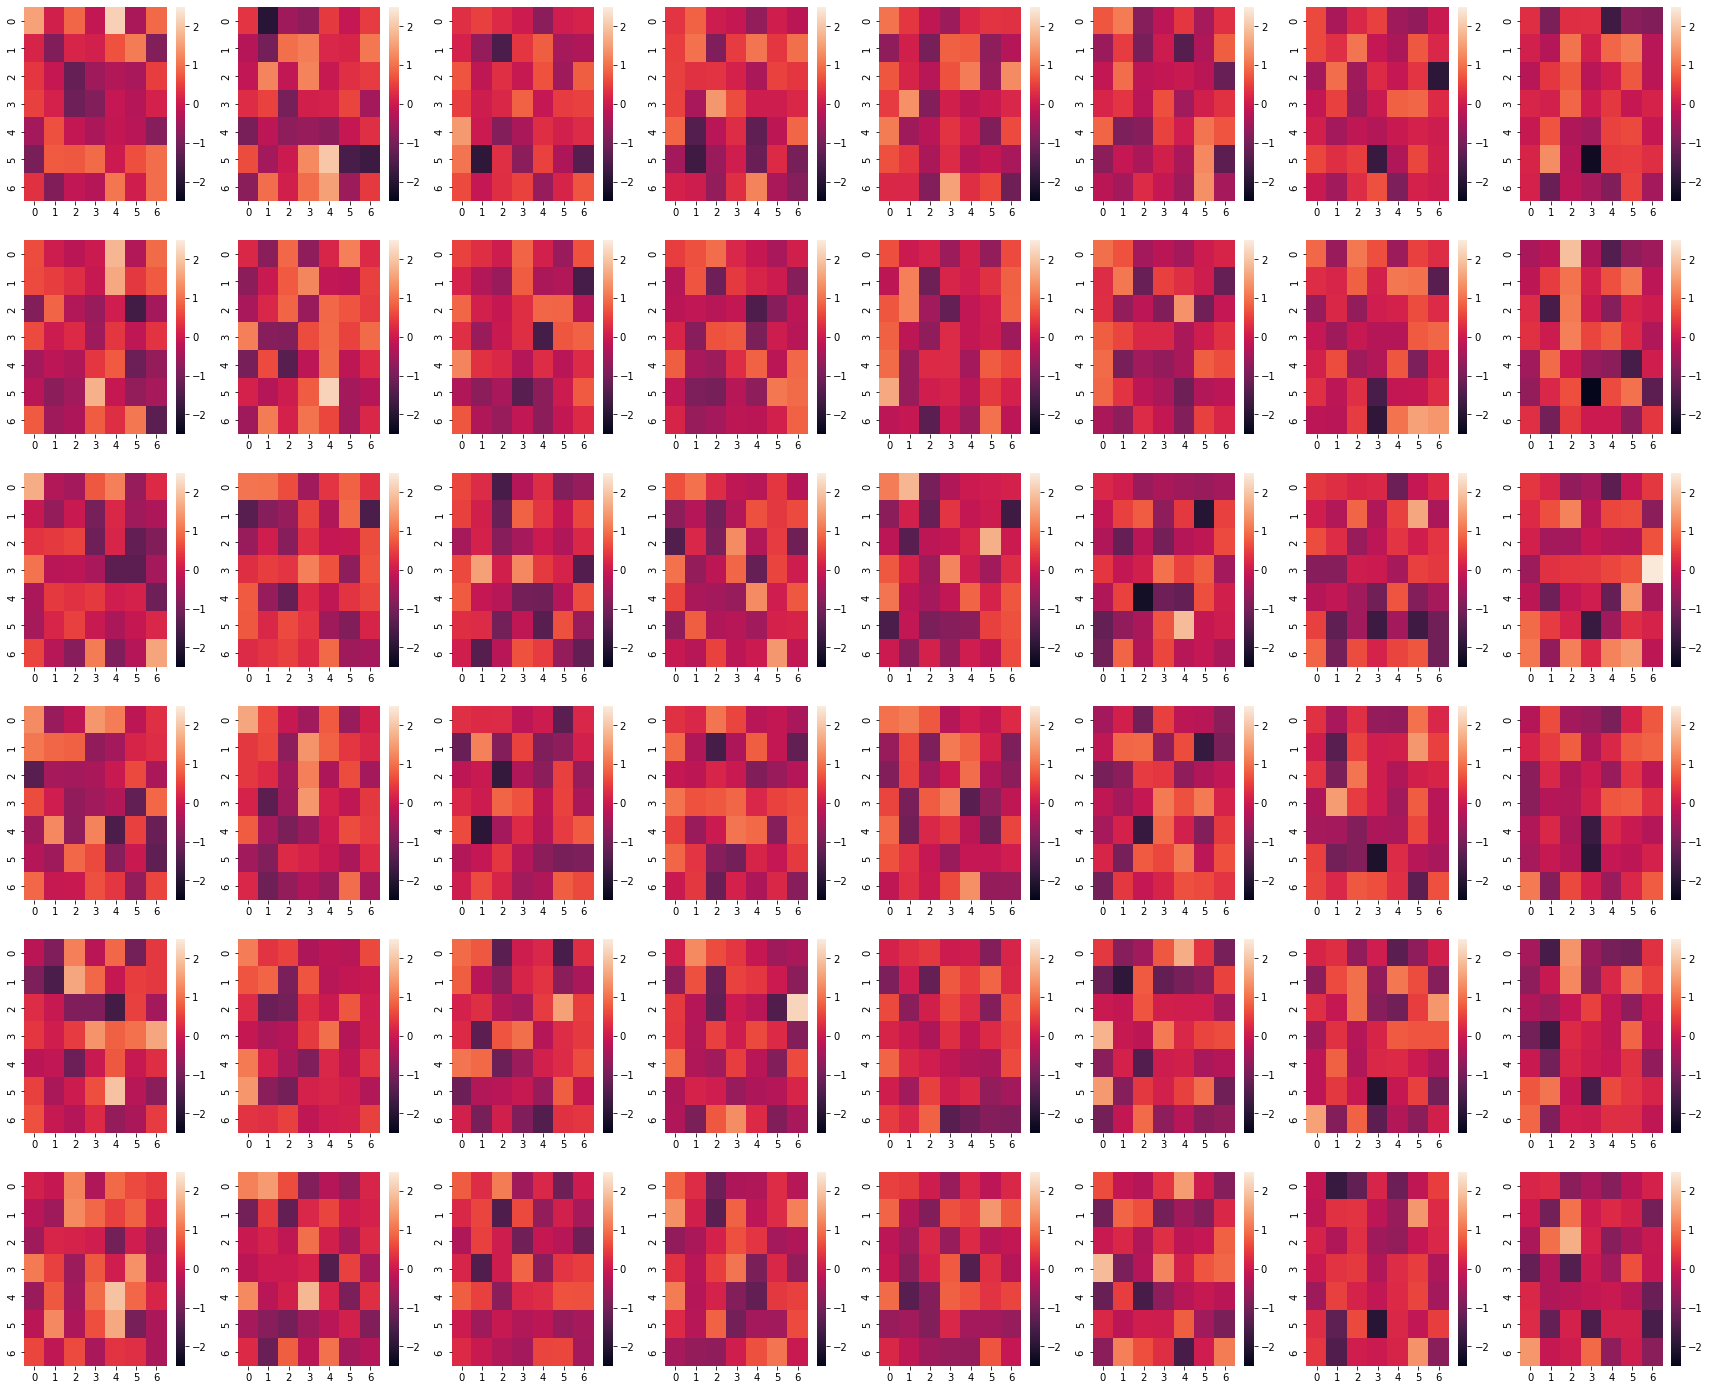

In [123]:
fig, ax = plt.subplots(6,8, figsize=(30,25))

row_i = 0
col_i = 0

for x in neuro_encodings:
    x = x.reshape(7,7)
    
    sns.heatmap(x, vmax=2.5, vmin=-2.5, ax=ax[row_i][col_i])

    row_i += 1
    if row_i == 6:
        col_i+=1
        row_i = 0
    

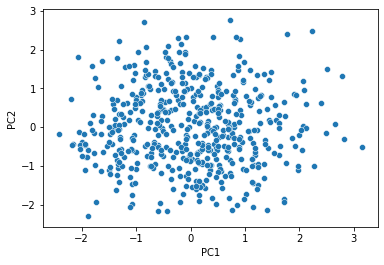

In [138]:
pca = PCA(n_components=2)

embeddings = pca.fit_transform(neuro_encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2")

In [124]:
flag = True
for sample in dataloader_bs1:
    
    sample = np.array(sample)
    sample = torch.Tensor(sample)

    if flag:
        encodings = vae.encoder(sample).detach().numpy()[0]
        flag = False
        continue
    
    encodings = np.vstack([encodings, vae.encoder(sample).detach().numpy()[0]])

In [116]:
meta.Group

assay_id
30960    HCC
30961    HCC
31008    HCC
31009    HCC
31488    HCC
        ... 
36299    CRC
36344    CRC
36347    CRC
36350    CRC
36416    CRC
Name: Group, Length: 518, dtype: object

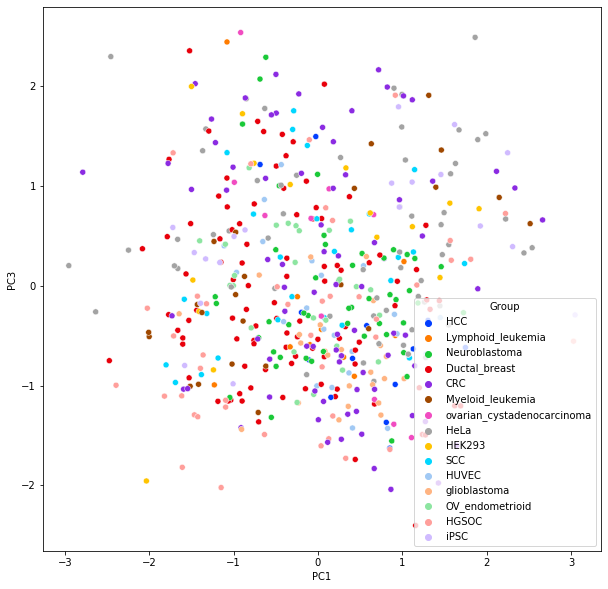

In [135]:
plt.figure(figsize=(10,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

pca = PCA(n_components=3)

embeddings = pca.fit_transform(encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["PC1", "PC2", "PC3"]), x= "PC1", y = "PC3", hue = meta.reset_index()["Group"], palette=colors)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


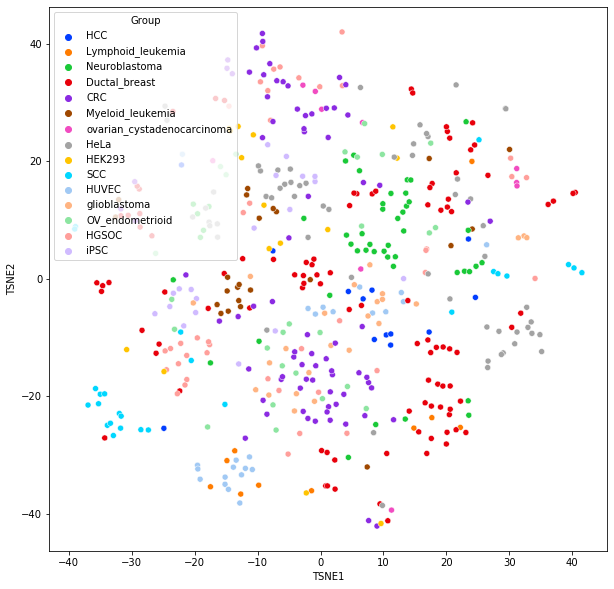

In [137]:
plt.figure(figsize=(10,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

tsne = TSNE(perplexity=15)

embeddings = tsne.fit_transform(encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette=colors)

How different are the samples after being reconstructed?

In [180]:
flag = True
for sample in dataloader_bs1:
    
    sample = np.array(sample)
    sample = torch.Tensor(sample)

    if flag:
        reconstructed_samples = vae.decoder(vae.encoder(sample)).detach().numpy()[0]
        flag = False
        continue
    
    reconstructed_samples = np.vstack([reconstructed_samples, vae.decoder(vae.encoder(sample)).detach().numpy()[0]])


In [185]:
reconstructions = pd.DataFrame(reconstructed_samples, columns= processed_data_df.columns)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


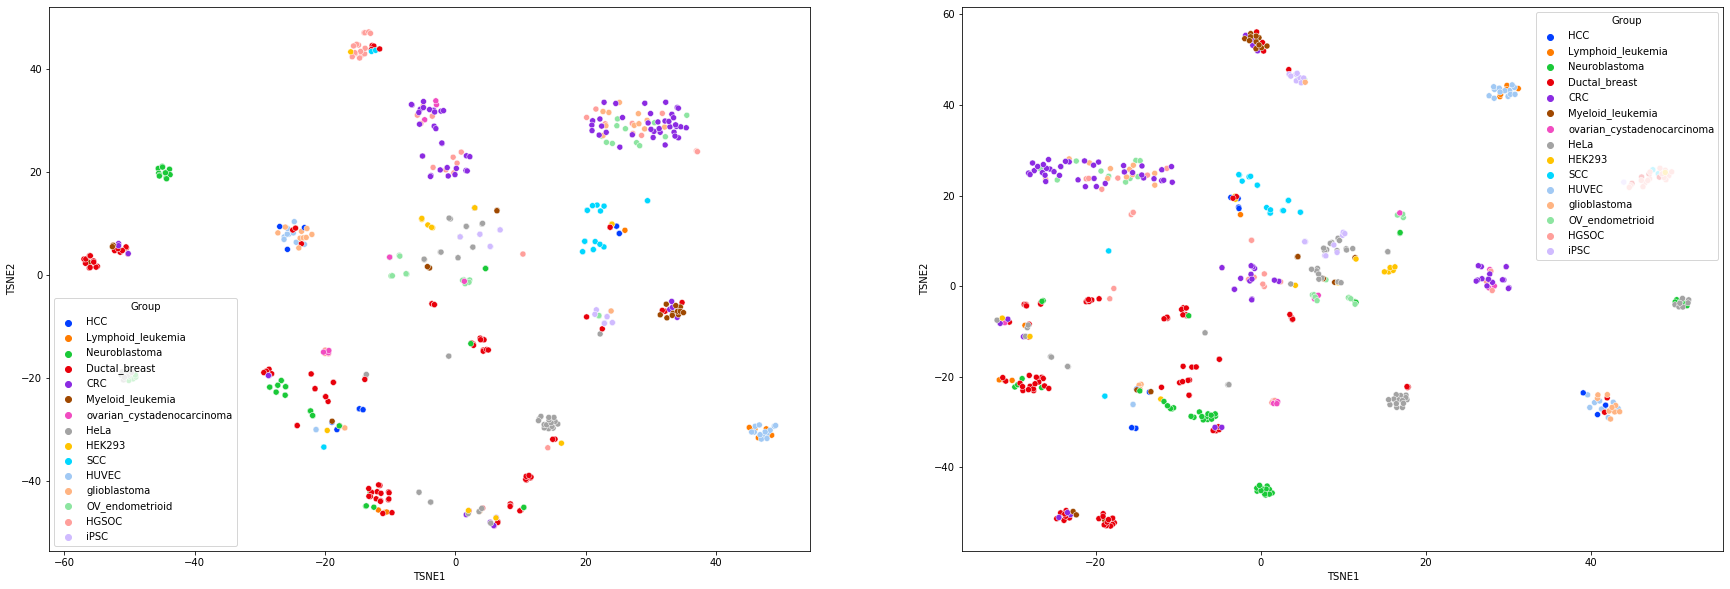

In [188]:
fig, ax = plt.subplots(1,2, figsize=(30,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

tsne = TSNE(perplexity=15)

embeddings = tsne.fit_transform(processed_data_df)
embeddings_reconstructed = tsne.fit_transform(reconstructions)

sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette=colors, ax=ax[0])
sns.scatterplot(data=pd.DataFrame(embeddings_reconstructed, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette=colors, ax=ax[1])

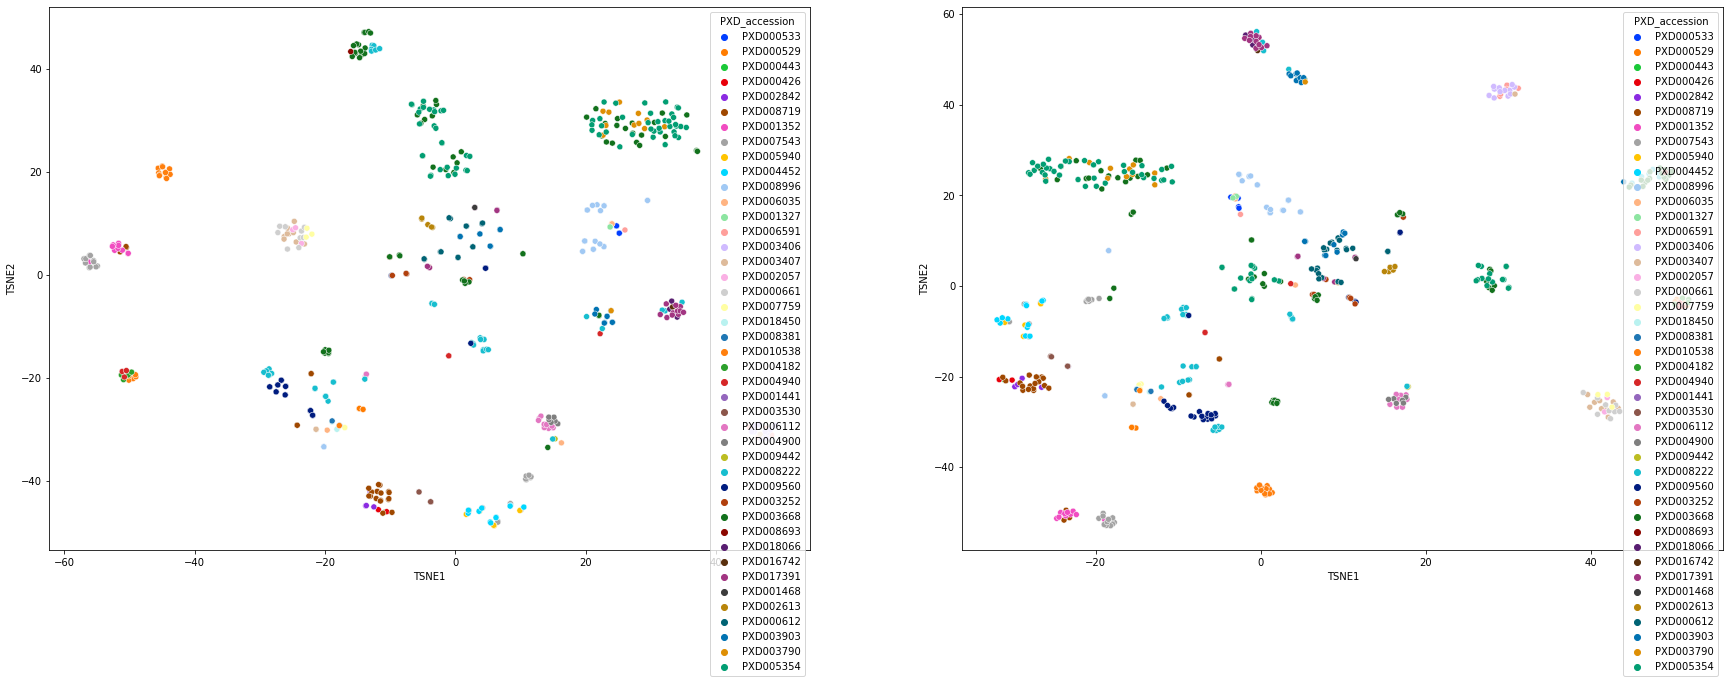

In [197]:
fig, ax = plt.subplots(1,2, figsize=(30,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel") + sns.color_palette("tab10") + sns.color_palette('dark') + sns.color_palette('colorblind')
colors = colors[:43]

sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["PXD_accession"], palette = colors, ax=ax[0])
sns.scatterplot(data=pd.DataFrame(embeddings_reconstructed, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["PXD_accession"], palette=colors, ax=ax[1])

Check reconstruction of 1 sample

In [223]:
dataloader_neuro = torch.utils.data.DataLoader(neuroblast_data.to_numpy(), batch_size = 1, shuffle=False)

flag=True
for i, sample in enumerate(dataloader_neuro):

    if flag:
        reconstructed_samples = vae.decoder(vae.encoder(sample)).detach().numpy()[0]
        neuro_encodings = vae.encoder(sample).detach().numpy()[0]
        flag = False
        continue
    
    neuro_encodings = np.vstack([neuro_encodings, vae.encoder(sample).detach().numpy()[0]])
    reconstructed_samples = np.vstack([reconstructed_samples, vae.decoder(vae.encoder(sample)).detach().numpy()[0]])

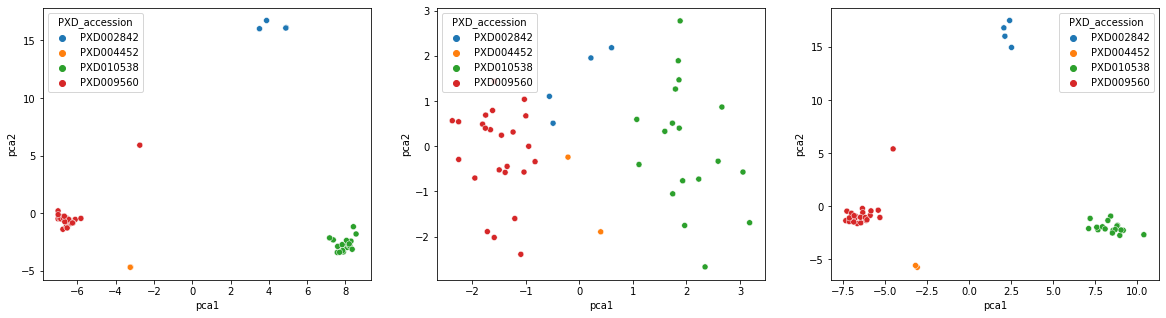

In [227]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

pca = PCA(n_components=2)

embeddings = pca.fit_transform(neuroblast_data)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"], index=neuroblast_data.index), x= "pca1", y = "pca2", hue = meta.loc[neuroblast_data.index,:].PXD_accession, ax=ax[0])

embeddings = pca.fit_transform(neuro_encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"], index=neuroblast_data.index), x= "pca1", y = "pca2", hue = meta.loc[neuroblast_data.index,:].PXD_accession, ax=ax[1])

embeddings = pca.fit_transform(reconstructed_samples)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"], index=neuroblast_data.index), x= "pca1", y = "pca2", hue = meta.loc[neuroblast_data.index,:].PXD_accession, ax=ax[2])

---

In [ ]:
plt.figure(figsize=(10,10))

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

tsne = TSNE(perplexity=15)

embeddings = tsne.fit_transform(encodings)
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette=colors)

In [141]:
meta[meta.Group == "Neuroblastoma"].index

Int64Index([31102, 31103, 31104, 31105, 35009, 35097, 31593, 31598, 31603,
            31608, 31613, 31618, 31623, 31628, 31633, 31638, 31643, 31648,
            31653, 31658, 31663, 31668, 31673, 31678, 31706, 31707, 31708,
            31709, 31710, 31711, 31712, 31725, 31726, 31727, 31728, 31729,
            31713, 31714, 31715, 31716, 31717, 31718, 31719, 31720, 31721,
            31722, 31723, 31724],
           dtype='int64', name='assay_id')

In [174]:
processed_data.shape

(518, 2615)

In [171]:
vae.decoder(vae.encoder(neuro_sample))

tensor([[4.6499e-01, 6.6831e-01, 1.9947e-04,  ..., 5.2189e-01, 7.2257e-02,
         2.3699e-02]], grad_fn=<SigmoidBackward0>)